# Verb Collocations with Atelic Time Duration Adverbials:
## A Collostructional Approach

In this notebook, I develop procedures to select and analyze atelic, durative time phrases within Biblical Hebrew. In English these phrases are communicated with the "for" construction: e.g. X happened for three days. These phrases are important since they are used in telicity tests for lexical aspect. The fundamental assumption is that atelic durative time phrases do not normally combine with telic verb lexemes:

> Durative adverbials also have an aspectual feature: they state specific bounds of a situation. They are compatible with durative atelic verb constellations and statives, and incompatible with durative telic verb constellations...(Smith, *The Parameter of Aspect*, 1997: 113)

In Fuhs' 2010 study, ["The Aspectual Coercion of the English Durative Adverbial,"](https://philpapers.org/rec/FUHTAC) he tests this assumption using collostruction analysis. This method, developed by Stefanowitsch and Gries ([see description here](http://www.linguistics.ucsb.edu/faculty/stgries/research/2003_AS-STG_Collostructions_IJCL.pdf)), tests the collocational preferences between a given construction and other lexical items. Those preferences are measured through a statistical test for significance, the Fisher's Exact test. Fuhs finds that 75% of the verb lexemes found to be statistically associated with atelic durative time adverbials do indeed have atelic aspect. Yet 25% of the verbs were truly telic. Fuhs also checks whether these 25% occur in the progressive aspect, which can construe telic action duratively. He finds that they do not, meaning that these cases are truly telic verb lexemes being construed as atelic. These findings suggest that the relationship between temporal adverbials and lexical aspect is more complex than is sometimes understood. 

In this notebook, I seek to apply Fuhs' methodology to the atelic durative time adverbials of Biblical Hebrew, to see whether his results are paralleled in the Biblical Hebrew data. The first step is to identify which forms in Biblical Hebrew indicate atelic, durative functions. The ETCBC Hebrew syntax database indicates adjunct phrases with a function of communicating "Time." For this pilot study, these phrases will serve as the primary target of investigation.

In [the exploratory analysis](SBH_time_expressions.ipynb), I found that noun-phrase based time adverbials have two primary forms: NPs governed by a preposition (PP), and bare NPs. Amongst these two groups are further divisions between noun phrases modified with a quantifier or a demonstrative (including the demonstrative ה). A preliminary search leading up to this pilot study futher found that the durative atelic time construction in Biblical Hebrew appears to be conveyed by bare NP's without any demonstrative element, often with quantification or plurality. While demonstratives or prepositions locate an event within a metaphorical space (e.g. this = near, that = far), bare noun phrases have no element which pinpoints a point or range along a timeline. Quantifiers and plural endings, by contrast, only serve to modify the length of time duration, and do not indicate positionality along a timeline. The result, then, is that the functional emphasis on time adverbials without prepositions or demonstratives falls on the duration itself. 

That durative, atelic time constructions in Biblical Hebrew are not directionally marked makes Biblical Hebrew similar to most other world languages, as Haspelmath observes:

> The most striking tendency observed in the expression of atelic-extent adverbials is the cross-linguistic tendency for zero expression or expression by means of a "minimal case". (Haspelmath 1997: 120)

Haspelmath points out that English is among a few other Indo-European languages that employ a preposition such as "for" to indicate atelic duration, while the majority use the zero-marking described above.

In [1]:
# ETCBC's BHSA data
from tf.app import use

# stats & data-containers
import collections, random
import pandas as pd
import numpy as np
import scipy.stats as stats
from pyscripts.significance import contingency_table, apply_fishers

# data visualizations
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# load BHSA and heads data
A = use('bhsa', mod='etcbc/heads/tf,CambridgeSemiticsLab/BH_time_collocations/tf', hoist=globals())
A.displaySetup(condenseType='clause') # configure Hebrew display
TF.load('g_cons_utf8 trailer_utf8', add=True)

TF app is up-to-date.
Using annotation/app-bhsa commit 7f353d587f4befb6efe1742831e28f301d2b3cea (=latest)
  in /Users/cody/text-fabric-data/__apps__/bhsa.
Using etcbc/bhsa/tf - c rv1.6 in /Users/cody/text-fabric-data
Using etcbc/phono/tf - c r1.2 in /Users/cody/text-fabric-data
Using etcbc/parallels/tf - c r1.2 in /Users/cody/text-fabric-data
Using etcbc/heads/tf - c rv.1.11 in /Users/cody/text-fabric-data
Using CambridgeSemiticsLab/BH_time_collocations/tf - c rv1.1 in /Users/cody/text-fabric-data


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="provenance of BHSA = Biblia Hebraica Stuttgartensia Amstelodamensis">BHSA</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Writing/Hebrew" title="('Hebrew characters and transcriptions',)">Character table</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="BHSA feature documentation">Feature docs</a> <a target="_blank" href="https://github.com/annotation/app-bhsa" title="bhsa API documentation">bhsa API</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Api/Fabric/" title="text-fabric-api">Text-Fabric API 7.4.6</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Use/Search/" title="Search Templates Introduction and Reference">Search Reference</a>

  0.00s loading features ...
  0.01s All additional features loaded - for details use loadLog()


In [2]:
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

def barplot_counts(count_dict, title='', reverse_labels=False, size=(8, 6), text_size=14, rotation=None):
    '''
    Makes simple barplot from collections.Counter type objects.
    '''
    
    count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['count']).sort_values(ascending=False, by='count')
    n_bars = list(range(0, count_df.shape[0]))
    x_labels = [''.join(reversed(prep)) for prep in count_df.index] if reverse_labels else count_df.index
    plt.figure(figsize=size)
    sns.barplot(n_bars, count_df['count'], color='darkblue')
    plt.xticks(n_bars, x_labels, size=text_size, rotation=rotation)
    plt.yticks(size=text_size)
    plt.title(title, size=text_size)
    plt.ylabel('count', size=text_size)
    plt.show()
    return count_df

## Functional Clustering

In order to compare the durative function to other functions, we need to validate whether the unmarked forms discussed above truly cluster together as distinguished from other functions. Additionally, in order to test significance between a verbal lexeme and a function, we need to gather contingency data for other functions in the Hebrew Bible. 

In this section, I lay out an approach to semantic clustering, which is based in part on the methods I applied in [a study of noun semantics](www.codykingham.com/nouns2018). In that study, nouns were clustered together based on the similarities of their syntactic and lexical contexts. In this study, we already know that the selected phrases have an identical semantic function of indicating Time, but we want to further distinguish species, especially aspectual connotations, amongst the time phrases. When comparing nouns, one can count contexts with respect to a given lexeme. But how does one count contexts with respect to a phrase function?

In the intial [SBH_time_expressions](SBH_time_expressions.ipynb) study, we saw a few important divisions within the SBH materials. Let's have a look at the distributions within the whole Hebrew Bible.

4080 time phrases found...




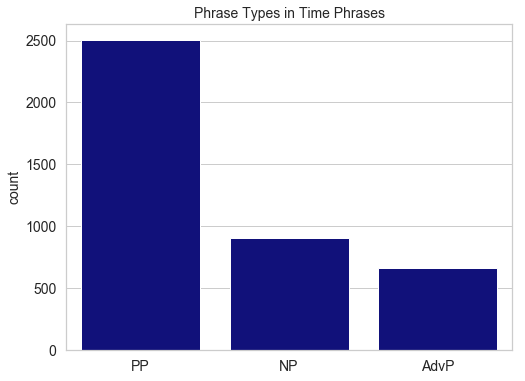

,count
PP,2507
NP,905
AdvP,668


In [3]:
phrase_type = A.search('''

phrase function=Time

''', shallow=True, silent=True)

print(len(phrase_type), 'time phrases found...\n\n')

p_type_count = collections.Counter()
for phrase in phrase_type:
    p_type_count[F.typ.v(phrase)] += 1
    
p_type_count = barplot_counts(p_type_count, title='Phrase Types in Time Phrases')
    
display(p_type_count)

2589 time prepositions found...




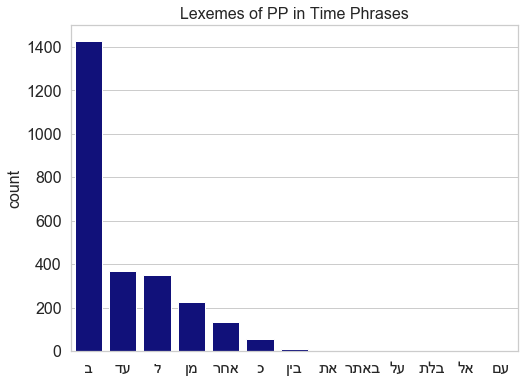

,count
ב,1429
עד,370
ל,349
מן,229
אחר,135
כ,55
בין,11
את,3
באתר,3
על,2


In [4]:
prep_lexes = A.search('''

phrase function=Time typ=PP
    <head- word pdp=prep

''', silent=True)

print(len(prep_lexes), 'time prepositions found...\n\n')

prep_count = collections.Counter()

for res in prep_lexes:
    prep_count[F.lex_utf8.v(res[1])] += 1

prep_count = barplot_counts(prep_count, 'Lexemes of PP in Time Phrases', reverse_labels=True, text_size=16)
    
display(prep_count)

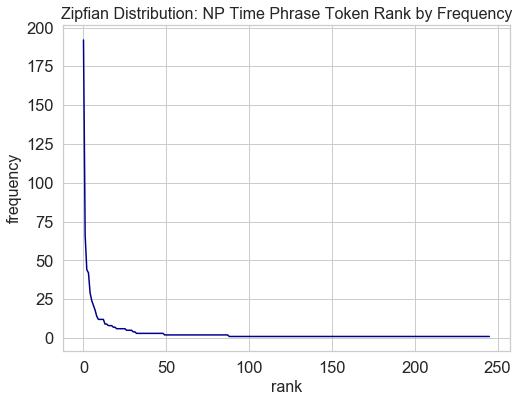

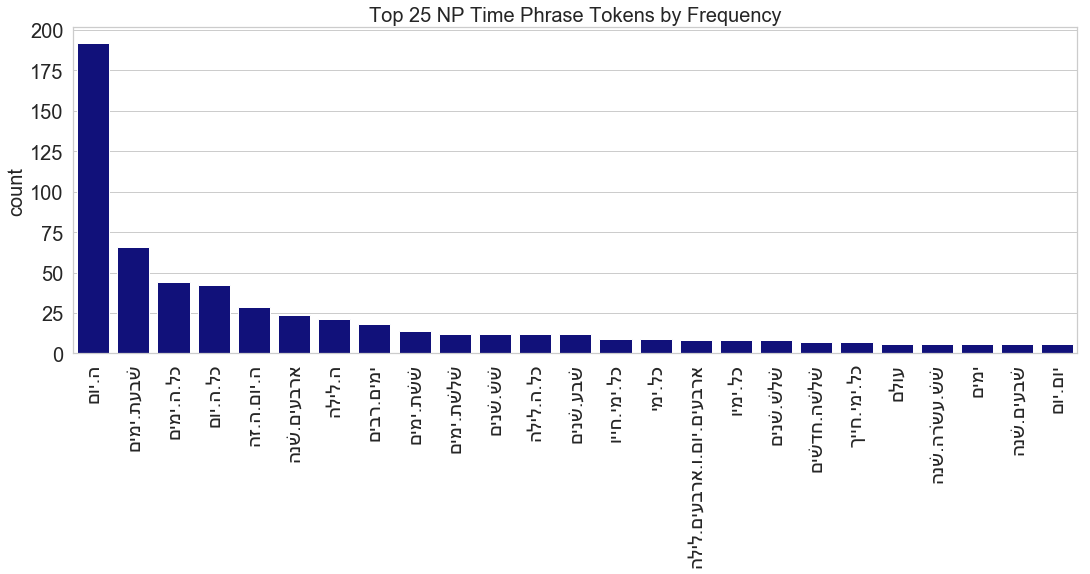

,count
ה.יום,192
שׁבעת.ימים,66
כל.ה.ימים,44
כל.ה.יום,42
ה.יום.ה.זה,29
ארבעים.שׁנה,24
ה.לילה,21
ימים.רבים,18
שׁשׁת.ימים,14
שׁלשׁת.ימים,12


In [6]:
np_time = A.search('phrase function=Time typ=NP', shallow=True, silent=True)

np_surface = collections.Counter()

for noun_p in np_time:
    text = '.'.join(F.g_cons_utf8.v(w) for w in L.d(noun_p, 'word'))
    np_surface[text] += 1
    
display(HTML(f'<h5>total number of tokens: {len(np_surface)}</h5>'))
print('\n\n')
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(np_surface)), sorted(np_surface.values(), reverse=True), color='darkblue')
plt.title('Zipfian Distribution: NP Time Phrase Token Rank by Frequency', size=16)
plt.xlabel('rank', size=16)
plt.ylabel('frequency', size=16)
    
np_surface_ct = barplot_counts(dict(np_surface.most_common(25)), 
                               size=(18, 6), 
                               reverse_labels=True, 
                               title='Top 25 NP Time Phrase Tokens by Frequency',
                               rotation='vertical', 
                               text_size=20)

display(np_surface_ct)

There seem to be essentially three main groups in these top surface forms: 1. those marked with a quantifier, such as a cardinal number or כל, plurality, but also with repetition as in יום יום, and 2. those marked mainly with ה or a demonstrative. Note also that יום dominates this list, 3. completely unmarked time as represented by עולם.

Let's see how much of the data these three groups account for.

In [53]:
# all
print('searching total NP time phrases...')
all_np_time = A.search('phrase function=Time typ=NP', shallow=True)

print('searching quantified...')
# group 1, quantified
quant_np = A.search('''

p:phrase function=Time typ=NP
/with/
    word sem_set=quant
/or/
    word nu=pl|du
/or/
    w1:word
    w2:word
    p <head- w1
    p <head- w2
    w1 # w2
    
lex
    w1
    w2
/-/
    
''', shallow=True)

print('searching demonstratives...')
# group 2, demonstrated
demon_np = A.search('''

phrase function=Time typ=NP
/with/
    word pdp=prde
/or/
    =: word pdp=art
/-/

/without/
    word sem_set=quant
/-/
''', shallow=True)

print('searching unmarked...')
# group 3, unmarked
unmarked_np = A.search('''

p:phrase function=Time typ=NP
/with/
    <head- w1:word nu#pl|du
    p =: w1
    p := w1
/-/
''', shallow=True)

found_results = set(quant_np)|set(demon_np)|set(unmarked_np)

print()
print(f'found: {len(found_results)} / {len(all_np_time)}')

searching total NP time phrases...
  0.27s 905 results
searching quantified...
  1.42s 615 results
searching demonstratives...
  0.67s 251 results
searching unmarked...
  1.05s 12 results

found: 875 / 905


In [54]:
groups = {'quant': quant_np, 'demon': demon_np, 'unmarked':unmarked_np}

print('overlap between sets:')
for groupi, resi in groups.items():
    print(groupi)
    for groupj, resj in groups.items():
        
        if groupi == groupj:
            continue
            
        print(f'\t{groupj}: {len(set(resi)&set(resj))}')

overlap between sets:
quant
	demon: 3
	unmarked: 0
demon
	quant: 3
	unmarked: 0
unmarked
	quant: 0
	demon: 0


In [58]:
len(set(all_np_time)-found_results)

30

**NOTES**

These groupings indeed distinguish the most amongst the dataset, though the patterns include a diverse group of searches, putting plurals and quantifieds together, for instance. These should probably be separated out into individual groups. 

## Building Test Sets

In [21]:
durative = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time typ=NP
    /without/
        word pdp=prep|prde|advb
    /-/
    /without/
        =: word pdp=art
    /-/
''')

  0.72s 199 results


In [61]:
#A.show(durative, withNodes=True, start=100, end=200)

In [29]:
simultaneous = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time typ=PP
    /without/
        word pdp=prde|advb
    /-/
        <head- word lex=B
''')

  1.24s 414 results


In [62]:
#A.show(simultaneous, withNodes=True, start=0, end=100)

In [32]:
demonstrative = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time
    /without/
        word pdp=advb
    /-/
        word pdp=prde
    
''')

  1.12s 222 results


In [63]:
#A.show(demonstrative, withNodes=True, start=0, end=100)

### Distinguishing from "Purposive Extent"
The atelic time duration is closely related to the "purposive extent," a function illustrated by the construction:

> Sibylle went to Paris for five years. (Haspelmath 1997: 128)

Haspelmath explains further:

> In purposive-extent constructions, the verbal event is not atelic, but the adverbial measures the length of the state resulting from this event. (Haspelmath 1997: 128)

Fuhs describes his method of dealing with this construction:

> In coding, I followed Smith’s suggestion to classify single for-phrases as instances of the durative construction, whereas in double marking, the second phrase was coded as a ‘purpositive extend’ [sic] (Haspelmath 1997: 128; Smith 1997: 114). After manually clearing the set, a total of 671 true instances of the English Durative Adverbial remained, which occurred in clauses in which no other aspect constructions in the periphery were present that could influence the predicate construal. This set was then used for a Collostructional Analysis. (Fuhs 2010: 145)

This procedure is the most vulnerable aspect of Fuhs's study. The purposive extent can occur without the doubling mentioned by Smith. This means that most of these cases would have to be manually sorted, and Fuhs himself would have had to decide whether a time phrase was purposive or not. Smith's criteria for purposive extent presents a circularity issue for Fuhs's manual sorting procedure:

> What triggers the shift [from telic event to atelic] is the incompatibility between the value of the verb constellations (telic) and the adverbials (atelic). (Smith 1997: 113).

Yet, the "compatibility" between the verb and the adverbials is precisely what Fuhs intends to measure. If he had used these notions in his manual sorting, they would might have affected the dataset he obtains.

### From...To Durations (מן...עד)